# Ensemble Methods Basic concepts

In [1]:
import addutils.toc ; addutils.toc.js(ipy_notebook=True)

In [2]:
import scipy.io
import numpy as np
import pandas as pd
from time import time
from sklearn import datasets, model_selection, metrics, ensemble, tree
from IPython.core.display import Image
from addutils import css_notebook
import matplotlib.pyplot as plt
%matplotlib inline
css_notebook()

In [3]:
import bokeh.plotting as bk
from bokeh.models import (GraphRenderer, StaticLayoutProvider, Rect, 
                          ColumnDataSource, Range1d, LabelSet, Label)
bk.output_notebook()

Loading BokehJS ...

## 1 Introduction

Ensemble Methods combine the predictions of several models in order to improve generalizability / robustness over a single model.

Among many ensemble methods, two of the most popular families of methods are:

* **B**ootstrap **agg**regation or **Bagging** (also called **Averaging**): train multiple models by randomly *sample with replacement (values can be duplicated)* from the dataset and then average (or vote) the predictions. Bagging seems to work better with High-Variance (Complex Models) by decreasing Variance *while the Bias is not affected*.<br>

  * **`RandomForestClassifier` / `RandomForestRegressor`<br>** splits are made with `0 < max_features < 1` and then the most discriminative threshold is used.
  * **`ExtraTreesClassifier` / `ExtraTreesRegressor`<br>** similar to RF but tresholds are drawn at random for each candidate feature.<br><br>

* **Boosting**: incrementally build an ensemble of *weak* classifiers to produce a powerful *'commitee'*. A *weak classifier* is only slightly better than random guessing. In boosting each new model is trained with a re-weighted version of the data to emphasize the training instances that previous models mis-classified. Boosting works the other way regard bias-variance decomposition, with respect to Bagging; it start with Low-Variance and High-Bias model and works by gradually improve Bias at each step. Increasing boosting steps tends to over-fit data and the algorithm is computationally more expensive than bagging.<br>

  * **`AdaBoostClassifier` / `AdaBoostRegressor`**
  * **`GradientBoostingClassifier` / `GradientBoostingRegressor`**

*In principle bagging and boosting are techniques that can be used with a variety of algorithms. In practice (expecially in the case of bagging) the preferred choice are trees (low-bias high-variance algorithm).*

### 1.1 Decision Trees

**Decision Trees** are supervised learning algorithms used for classification and regression. They work by partitioning the feature space into a set of rectangles, and then fit a simple model (i.e. a constant value) in each one. The following algorithm is the one used by CART, one of the most popular decision tree algorithm.

Suppose to have a regression problem with two variables $X_1$, $X_2$ and response variable $Y$ (A simple example of such space is visible in picture below). At the beginning the tree chooses a variable, let's say $X_1$, and split the region in two at a certain point $X_1 = t_1$, with values in $R_1$ for $X_1 \leq t_1$ and values in $R_2$ for $X_1 > t_1$. The two region are further divided and each time the algorithm chooses a variable and a split point (for example $X_2$ and $t_2$), until a certain criterion is met and the algorithm terminate. The reponse value in each region is the average value of $Y$ in that region. For classification problems the class of a region is the majority of classes of $Y$ that fall in that region.  

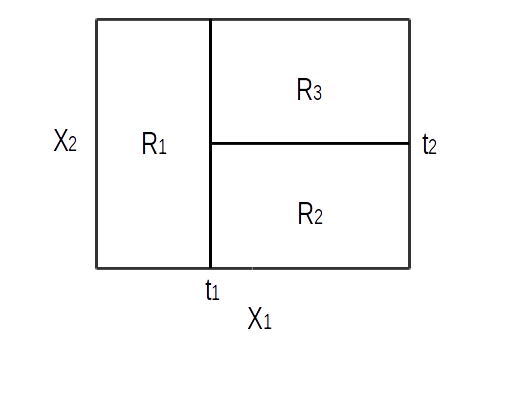

In [4]:
Image("images/tree.png")

In the case of regression the best combination of variable and split point is determined with a greedy strategy. For each variable the algorithm chooses the best splitting point (the one that minimize the residual sum of square in the two region) and among all the best pairs $<$*variable*, *split point*$>$.

For classification problems the criterion for choosing the splitting point is usually the **Gini index**. Gini index (or **Gini impurity**) is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it were randomly labeled according to the distribution of labels in the subset. Gini impurity can be computed by summing the probability of each item being chosen times the probability of a mistake in categorizing that item. The formula for the gini impurity measure is: $\sum_{k=1}^K p_{mk}(1-p_{mk})$, where $m$ is the terminal node and $K$ is the number of classes. It reaches its minimum (zero) when all cases in the node fall into a single target category. Gini impurity reaches its maximum value when all classes in the table have equal probability.

To illustrate the structure of a decision tree, we provide an example with the sklearn tree class. 

**NOTE:** please install graphviz before running this cell, otherwise a default tree image will be displayed. For <font color='red'>windows</font> users:
- go to [graphviz.org](http://www.graphviz.org) and install the software for your version
- close this notebook and jupyter. From the same Anaconda prompt type: `PATH=%PATH%;C:\Program Files (x86)\Graphviz2.38\bin` and then relaunch jupyter notebook (**NOTE:** this solution is not permanent. If you want to make it permanent, go to Environment Variables (Control Panel\All Control Panel Items\System\Advanced system settings, click Environment Variables button; under System variables find the variable path; click Edit... and then add C:\Program Files (x86)\Graphviz[version]\bin to the end in the Variable value: field.
- to confirm you can use dot command in the Command Line (Windows Command Processor), type dot -V which should return the software version.

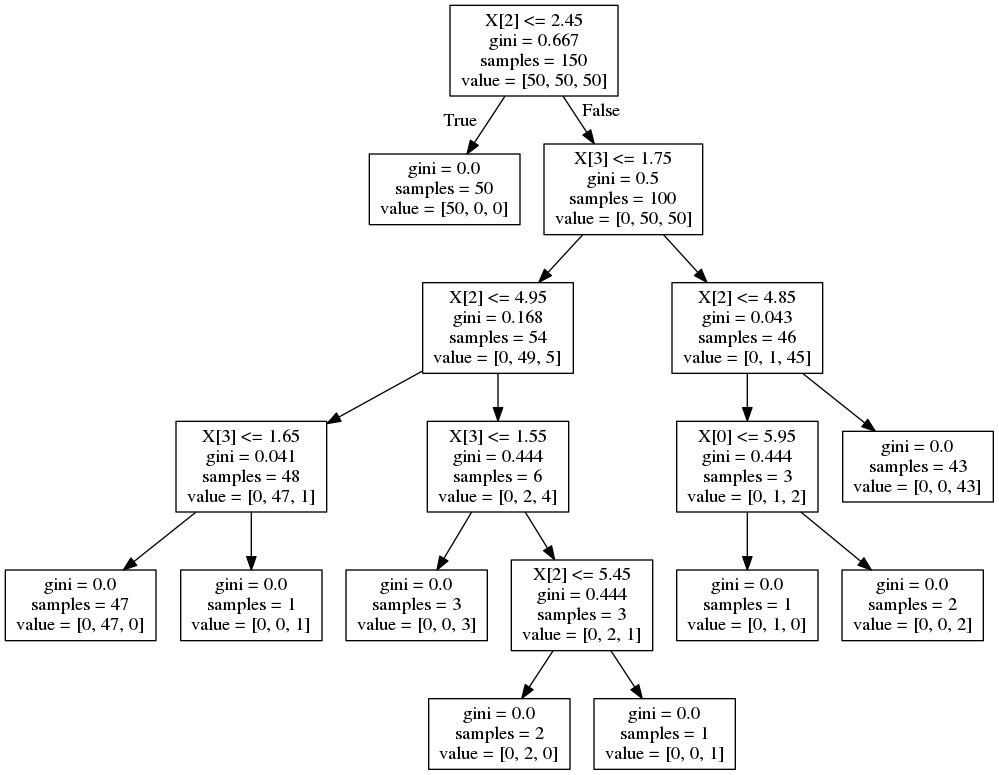

In [5]:
from sklearn.datasets import load_iris
from sklearn import tree
from io import StringIO
from pydot import graph_from_dot_data

iris = load_iris()
clf = tree.DecisionTreeClassifier()
clf = clf.fit(iris.data, iris.target)
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data)
graph = graph_from_dot_data(dot_data.getvalue())[0]
try:
    tree_image = Image(graph.create_png())
except:
    print('Graphviz is not installed on your system.\
          Please follow installation instructions if you want updated pictures')
    tree_image =Image("images/temp.png")
tree_image

**Decision Tree typical properties:**
- PROS
 - Conceptually simple to draw and interpret
 - Can handle categorical predictors and do not require normalization
- CONS
 - Tend to learn a too complex model (Overfit, High Variance)
 - Susceptible to outliers
 - Some concepts (for example XOR and additive functions) are hard to learn
 - Tend to favor categorical features with many categories, because the number of binary partitions grows exponentially with the number of categories. For this reason choosing the right split becomes hard causing overfit.

## 2 Random Forests

**Random Forest (RF)** works by building a large ensemble of de-correlated trees and then averages them. The algorithm uses a modified bagging, where each tree is built on a random subspace. Bagging averages a set of approximately unbiased models to reduce variance. Trees work well in this context because they can capture complex interaction in the data. In bagging, samples are not necessarily independent and thus averaging doesn't account for all variance. The variance of the average of i.d. variables with correlation $\rho$ is: $\rho \sigma^2 + \frac{1-\rho}{B}\sigma^2$ where $B$ is the number of trees in the ensemble and $\sigma^2$ is the variance of each variable. As $B$ increases the second term disappear but the first remains, thus the correlation between pairs of trees limits the benefit derived from averaging.

The idea of Random Forests is to reduce the correlation of each tree (and thus decrease variance) by *randomly selecting a subset of input variables for each split in the tree*. This procedure slightly increases bias but achieve a better variance reduction.

Random Forests are a popular method because they work surprisingly well with the default hyperparameters.

**The main hyperparameter to adjust is the number of variables selected at random for each split.** In sklearn this is called `max_features` and it's usually optimized with `grid search`. 

The recommended value for `max_features` is $\sqrt{p}$ (where $p$ is the total number of features) for classification problems or $\lfloor p/3 \rfloor$ for regression problems. These are rules of thumb and they work well for most datasets. In practice it is useful to start with the default and then refine the result. In principle **lower values of p reduce the correlation between any pair of trees and hence reduce the variance of the average, at the cost of sligtly increasing the bias of each tree**. Note that in scikit-learn the default value of `max_features` for regression is $p$ (use all features). 

In scikit-learn `max_features` can be used in several way:
- `int` $\to$ number of features to use
- `float` $\to$ percentage of features to use
- `auto` $\to$ $\sqrt{p}$ (classification) or $p$ (regression)
- `none` $\to$ all features.

**The second important parameter to tune is `n_estimators`: the number of trees in the forest. Since Random Forests are an averaging method they do not usually overfit by adding more trees and the larger the better (but it takes more time to compute.** In addition, note that results will stop in getting significantly better beyond a sufficient number of trees.

Random Forests are said to hardly overfit the data. This is not always the case and the average of fully grown trees can result in a model that is too rich and with too much variance. If this is a concern, there are few ways to reduce tree depth, either by specifying the limit directly or by setting the number of training samples in the leaf, or the minimum number of samples to split. In scikit-learn this parameters are:

- `max_depth` if `None` the nodes are expanded until pure or `min_samples_split`.
- `min_samples_split` minimum number of samples required to split an internal node. Large values lead to smaller trees, higher bias and smaller variance. The optimal value depends in principle on the noise level in the dataset: in noisy datasets, ensemble of fully grown trees will overfit the data.
- `min_samples_leaf` minimum number of samples in resulting leafs. 

If `n_jobs=k` then computations are partitioned into k jobs, and run on k cores of the machine. If n_jobs=-1 then all cores available on the machine are used.

In [6]:
pd.options.display.notebook_repr_html = True

iris = datasets.load_iris()
# We skip the scaling because the tree-based models are almost insensitive to scaling
df = pd.DataFrame(iris.data, columns=iris.feature_names)
# Split Training and Validation Sets
idx_train, idx_valid = model_selection.train_test_split(df.index, test_size=0.15)
df_train, df_valid = df.iloc[idx_train], df.iloc[idx_valid]
y_train, y_valid = iris.target[idx_train], iris.target[idx_valid]

print("Training set / Validation set number of samples: {0}, {1}".format(df_train.shape[0], 
                                                                         df_valid.shape[0]))
print("Number of features: {0}".format(df_train.shape[1]))

Training set / Validation set number of samples: 127, 23
Number of features: 4


In [7]:
rfc = ensemble.RandomForestClassifier()
params = {'n_estimators':[5, 15, 30, 50, 75, 100],
          'max_features':[2, 3, 4],
          'max_depth':[2, 4, 6, 8],
          'random_state':[0]}
t0 = time()
grid = model_selection.GridSearchCV(rfc, params, cv=15, n_jobs=-1)
grid.fit(df_train, y_train)
rfc_best = grid.best_estimator_

print(metrics.confusion_matrix(rfc_best.predict(df_valid), y_valid))
print('\nBest Params: N est:%3i - Mx feat:%2i - Mx dpth:%2i - F1:%.3f'\
      %(rfc_best.n_estimators, rfc_best.max_features, rfc_best.max_depth,
       metrics.f1_score(rfc_best.predict(df_valid), y_valid, average='micro')))
print(rfc_best)
print('Done in %0.3f[s]' %(time() - t0))

[[8 0 0]
 [0 7 0]
 [0 1 7]]

Best Params: N est: 15 - Mx feat: 3 - Mx dpth: 2 - F1:0.957
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Done in 7.268[s]


Let's have a look to one of the Random Forest Trees:

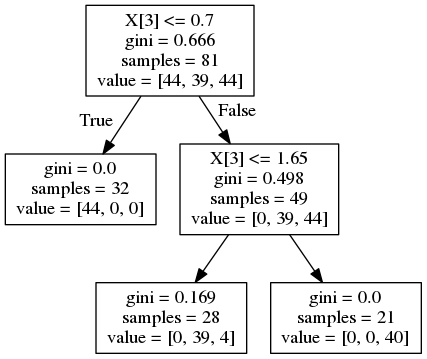

In [8]:
idx = 1
dot_data = StringIO()
tree.export_graphviz(rfc_best.estimators_[idx], out_file=dot_data)
graph = graph_from_dot_data(dot_data.getvalue())[0]
try:
    tree_image = Image(graph.create_png())
except:
    tree_image =Image("images/temp1.png")
tree_image

**samples** is the number of samples that will be classified in the specific leaf if the tree will be fed with the bootstrap set

**value** is the number of samples that will be classified in the specific leaf if the tree will be fed with the original dataset:

* bootstrap samples = 81
* total samples = 127
* sum of all elements in 'value' = 127

**Random Forests properties:**
- Properties derived from Trees:
    - Can handle categorical predictors and do not require normalization
    - Support natively multiclass problems
    - Some concepts (for example XOR and additive functions) are hard to learn
    - Tend to favor categorical features with many categories
- Typical properties:
    - In sklearn classification trees uses a probability distribution in the leafs rather than majority voting. This methods produces a better overall prediction and at the same time can provide also a probability measure of the class membership (not only a pure class vote).
    - If the number of relevant features is small, Random Forests can perform poorly, because at each split the probabilty of picking irrelevant variables is higher

**Random Forests Advanced topics**

Other than regression and classification, Random Forests provide much more information that are useful for different tasks. Some of them apply equally well to other ensemble methods such as Gradient Boosting Trees. Here we review the main concepts while the detailed descriptions are given in the advanced notebook.

- *Out Of Bag (OOB) estimate*: during the building phase of each tree some samples are left out. These samples are called OOB samples. Using OOB samples a generalization measure can be calculated without relying on a Validation Test Set. This measure is called Out Of Bag score (or OOB estimate).<br><br>

- *Variable importance*: trees (and ensemble of trees) can provide a measure indicating how important or useful a variable is in predicting the outcome. Scikit-learn calculate the variable importance from the improvement to the gini index every variable provide at each split. There at least another more reliable algorithm to calculate the Variable Importance that is freely available in the Addfor libraries.<br><br>

- *Feature selection*: allows to reduce dimensionaly and thus improve algorithm speed and convergence while keeping the most of the capabilities. The procedure can be automated to remove the last feature until certain stopping criterion (e.g. decrease in accuracy) is met.<br><br>

- *Partial dependence*: it shows the relation between the target and a chosen set of varialbe (at most two at a time), marginalizing over the other variables. The chosen variables are usually the most important and this plot is used to gain insight about the function learned by the ensemble and how it models the dependence between the target and the most important variables.<br><br>

- *Proximity measure*: random forest can grow a $N \times N$ proximity matrix, constructed by passing the OOB samples through each tree and increasing the proximity of two sample if they ends up in the same terminal node. Plotting this matrix should provide insight on which data points are effectively close, at least as learned by the random forest classfier. However it tends to produce similar graphs and its utility has been doubted.<br><br>

## 3 Extremely Randomized Trees

In **Extremely Randomized Trees** (or **E**xtra **T**rees, **ET**), randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, **thresholds are drawn at random for each candidate feature**. The relation with the output is retained by selecting the best couple $<$_feature_, _random-threshold_$>$ as the splitting point (if `max_features` = 1, the trees would be totally random).

It is possible to interpret this choice in different ways. If a feature is important, a significant fraction of the trees will have (approximately) the same feature with the same split point at the same position in the tree. This increases the correlation of each tree, hence increasing variance. By randomly selecting the threshold the algorithm introduces a *slightly increase in Bias* but it usually allows to *reduce the Variance* of the model a bit more.

In [9]:
rfc = ensemble.ExtraTreesClassifier()
params = {'n_estimators':[5, 15, 30, 50, 75, 100],
          'max_features':[2, 3, 4],
          'max_depth':[2, 4, 6, 8]}
t0 = time()
grid = model_selection.GridSearchCV(rfc, params, cv=15, n_jobs=-1)
grid.fit(df_train, y_train)
rfc_best = grid.best_estimator_

print(metrics.confusion_matrix(rfc_best.predict(df_valid), y_valid))
print('\nBest Params: N est:%3i - Mx feat:%2i - Mx dpth:%2i - F1:%.3f'\
      %(rfc_best.n_estimators, rfc_best.max_features, rfc_best.max_depth,
       metrics.f1_score(rfc_best.predict(df_valid), y_valid, average='micro')))
print(rfc_best)
print('Done in %0.3f[s]' %(time() - t0))

[[8 0 0]
 [0 8 0]
 [0 0 7]]

Best Params: N est: 15 - Mx feat: 3 - Mx dpth: 2 - F1:1.000
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=2, max_features=3, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Done in 7.035[s]


**Extremely Randomized Trees properties:**
- Properties derived from Trees:
    - Can handle categorical predictors and do not require normalization
    - Support natively multiclass problems
    - Some concepts (for example XOR and additive functions) are hard to learn
    - Tend to favor categorical features with many categories
- Typical properties:
    - Since the splitting point is draw at random, the computational cost of selecting the split point is reduced.
    - In scikit-learn the implementation is similar to that of Random Forest (except for the random choice of threshold), whereas the original algorithm is somewhat different (no bagging).

## 4 AdaBoost

**AdaBoost**, short for **Ada**ptive **Boost**ing, is a meta-algorithm, and can be used in conjunction with many other learning algorithms. The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. Each iteration in the sequence puts more weights on difficoult examples (examples that are misclassified in previous iterations). The predictions from all of them are then combined through a *weighted* majority vote (or sum) to produce the final prediction. AdaBoost is sensitive to noisy data and outliers. The classifiers it uses can be weak (i.e., display a substantial error rate), but as long as their performance is slightly better than random, they will improve the final model.

In [10]:
adb = ensemble.AdaBoostClassifier()
params = {'n_estimators':[10, 20, 30, 40],
          'learning_rate':[0.1, 0.2, 0.5, 0.7, 1.0]}
t0 = time()
grid = model_selection.GridSearchCV(adb, params, cv=15)
grid.fit(df_train, y_train)
adb_best = grid.best_estimator_

print('Done in'.ljust(20), ': %.3f[s]' %(time() - t0))
for key, value in grid.best_params_.items():
    print(key.ljust(20), ':', value)
print('F1 Score'.ljust(20), ': %.3f' %(metrics.f1_score(adb_best.predict(df_valid), 
                                                        y_valid, average='micro')))
print('\nConfusion Matrix:')
print(metrics.confusion_matrix(adb_best.predict(df_valid), y_valid))

Done in              : 7.679[s]
learning_rate        : 1.0
n_estimators         : 20
F1 Score             : 0.913

Confusion Matrix:
[[8 0 0]
 [0 7 1]
 [0 1 6]]


**AdaBoost** can be used with a variety of base estimators. This can be an advantage over **Gradient Boosting** that uses trees, because it is possible to further the analysis process with more variants. However Gradient Boosting uses a slightly different algorithm and since base estimators is predetermined it needs one less parameter to tune. Generally for the particular choice of the loss function **AdaBoost** is sensitive to outliers, because  squared-error loss places much more emphasis on observations with large absolute residuals. **Gradient Boosting**,  instead, support robust loss function and it is less sensitive to outliers.

## 5 Gradient Boosting Regression Trees (GBRT)

**Gradient Boosting** is a technique to build additive regression models by sequentially fitting a simple parametrized function (weak learner) to current "pseudo residuals" by least squares at each iteration. The pseudo residuals are the gradient of the loss functional being minimized with respect to the model values at each data points, evaluated at the current step. Basically it is a numerical optimization in function space rather than parameter space.

**Gradient Tree Boosting** or **G**radient **B**oosted **R**egression **T**rees **(GBRT)** is a special case of *Gradient Boosting* where the weak learners are regression trees. It's made for regression and can be adapted to classification. The method was invented by *Jerome H. Friedman in 1999*. 

The main meta-parameters to adjust are the *Tree Size* and the amount of *Regularization*. For each of these meta-parameters scikit-learn offers a serie of knobs to adjust. Let's briefly review them.

**Tree Size**

The size of each tree is an important parameter. If trees are too large they tend to decrease performance and increase computational costs. The optimal tree size is problem dependent and can be controlled with these parameters:
- `max_depth`: it controls the maximum allowed level of interaction between variables. With `max_depth = 2` the tree has up to one root node two internal nodes and four leaves. With this tree the model will include the effects of the interaction between two variables at most. The depth is the level of possible variable interaction. The interaction value between variables is generally unknown, but in most cases it is a low value. In many applications `max_depth = 2` is too low, while `max_depth > 10` it is unlikely required. Practical experience indicates typical values for this parameter in the range $4 \leq$ `max_depth` $\leq 8$. 
- `max_leaf_nodes`: alternative way to control the depth of the trees.  A tree with `max_leaf_nodes = n` has at most n - 1 split nodes and can model interaction of order max_leaf_nodes - 1, this beahavior is similar to `max_depth = n-1` but the resulting trees are slightly unbalanced and are less sensitive to additivity. Moreover it should be faster to train at the expense of a slightly higher training error. 
- `min_sample_leaf`: it puts a constraint on the number of samples in each leaf, hence it reduces the effects of outliers (you cannot have for example leaf with one node)

**Regularization**

Controlling the number of boosting iterations is also problem dependent. Each iteration reduce the training error, so that given a sufficient number of iteration this number can be made arbitrarily small. However this can cause overfitting. Thus there is an optimal number of iteration that must be found. There are also other ways to perform 
regularization. 
Let's review main parameters in this area:

* _shrinkage:_
    - `n_estimators`: The number of boosting stages to perform (default=100). It is the main parameter to control regularization. 
    - `learning_rate`: this controls the Shrinkage, that is another form of regularization. It's a scale factor applied to tree predictions. Default is $0.1$. A decrease in `learning_rate` (increase in Shrinkage) has the effect of "reinforce concept": the redundancy between trees increases. The effect is that the model with high Shrinkage usually requires more trees but show a much better Variance.
    
* _subsampling:_
    - `subsample`: Choosing subsample $< 1.0$ leads to a reduction of variance and an increase in bias. It's the fraction of samples to be used for fitting the individual base learners. These two parameters are similar to the ones used in Random Forest and are used for the same purpose: introduce randomization and improve on Variance
    - `max_features`: The number of features to consider when looking for the best split. The lower the greater the reduction of variance, but also the greater the increase in bias. As for the Random Forest, use `int` $\to$ number of features ot use, `float` $\to$ percentage of features to use, `auto` $\to$ $\sqrt{n\_feat}$, `none` $\to$ all features. 

Other parameters include choosing the loss function. Several loss function can be used, and as specified with the parameter `loss`.

Also GBRT allows to compute OOB estimate with the samples not included in the bootstrap sample. The OOB score are stored in the attribute `oob_improvement_.oob_improvement_[i]` and can be used for model selection, for example to set the optimal number of iterations. OOB scores are usually very pessimistic respect to cross validation but the latter is too time consuming.

Scikit-learn implementation offers also an additional parameter `warm_start=True` that allows to add more trees to an existing model.

### 5.1 Gradient Boosting Parameter Tuning

In the following examples we show how each meta-parameter affects GBRT performance. 

In this example we use a synthetic dataset used in the book *Elements of Statistical Learning by Hastie et al.* and available in scikit-learn. The function `make_hastie_10_2` generates a dataset for classification. The features $X_1, \ldots, X_n$ are standard independent Gaussian and the target function is defined by:

$$ Y = 
    \begin{cases}
    1 & if \sum_{j=1}^{10} X_j^2 > \chi_{10}^2(0.5),\\
    -1 & otherwise.
    \end{cases}
$$

In [11]:
X_hastie, y_hastie = datasets.make_hastie_10_2(n_samples=12000, random_state=42)
X_hastie = X_hastie.astype(np.float32)

# map labels from {-1, 1} to {0, 1}
labels, y_hastie = np.unique(y_hastie, return_inverse=True)

X_hastie_train, X_hastie_test = X_hastie[:2000], X_hastie[2000:]
y_hastie_train, y_hastie_test = y_hastie[:2000], y_hastie[2000:]

**Tree size**

In the following examples we will try to understand how tree size parameters affects the resulting tree shape and then we will see how tree size affects GBRT error varying the number of estimators.

Let's see how `max_leaf_nodes` and `max_depth` affect the resulting tree structure. First we choose `max_leaf_nodes` = 4 and later we choose `max_depth` = 2. If `max_leaf_nodes` is specified, `max_depth` is ignored; the default value of `max_leaf_nodes` is `None` and in that case only `max_depth` is used. Despite having the same number of leaves (4) the trees are slighlty different. 

In the first example (`max_leaf_nodes` = 4) the tree is grown in a greedy best-first fashion, at each split the node with the highest impurity is chosen to be further split while the node with lower impurity becomes a leaf. The resulting tree is unbalanced with leaves at every level.

In [12]:
gbrt = ensemble.GradientBoostingClassifier(n_estimators=1000, 
                                           max_leaf_nodes=4, 
                                           random_state=42)
gbrt.fit(X_hastie_train, y_hastie_train)
y_gbrt = gbrt.predict(X_hastie_test)

print("F1 score: {0}".format(metrics.f1_score(y_gbrt, y_hastie_test)))

F1 score: 0.9279123998783332


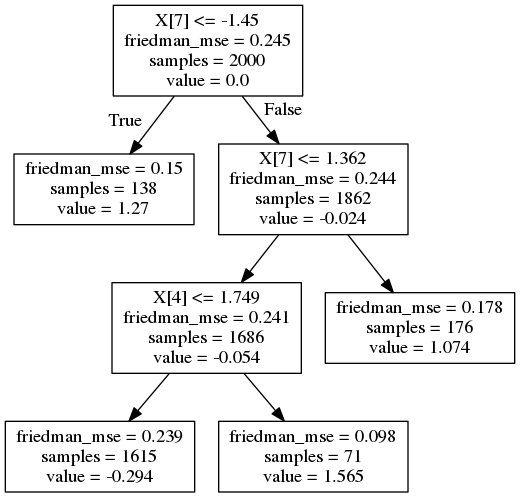

In [13]:
idx = 1
dot_data = StringIO()
tree.export_graphviz(gbrt.estimators_[idx][0], out_file=dot_data)
graph = graph_from_dot_data(dot_data.getvalue())[0]
try:
    tree_image = Image(graph.create_png())
except:
    tree_image =Image("images/temp2.png")
tree_image

In the following example, specifying the depth implies that leaves are expanded for every internal nodee until the desired depth is reached. The resulting tree is balanced with $2^d$ leaves, where $d$ is the depth of the tree.

In [14]:
gbrt = ensemble.GradientBoostingClassifier(n_estimators=1000, 
                                           max_depth=2, 
                                           random_state=42)
gbrt.fit(X_hastie_train, y_hastie_train)
y_gbrt = gbrt.predict(X_hastie_test)

print("F1 score: {0}".format(metrics.f1_score(y_gbrt, y_hastie_test)))

F1 score: 0.9214766469508465


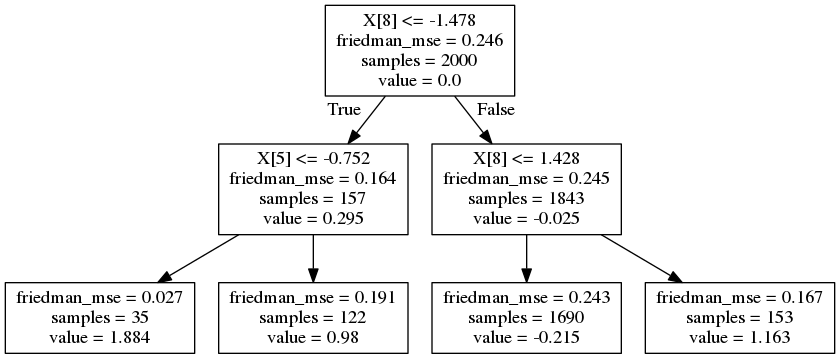

In [15]:
idx = 1
dot_data = StringIO()
tree.export_graphviz(gbrt.estimators_[idx][0], out_file=dot_data)
graph = graph_from_dot_data(dot_data.getvalue())[0]
try:
    tree_image = Image(graph.create_png())
except:
    tree_image =Image("images/temp3.png")
tree_image

The difference between the two trees is really subtle. One can argue that the first tree looks like it was pruned. Allowing unbalance in the tree growing process can result in a tree that better follows the interaction of the variables (a variable that interact with another results in a split of first followed by a split of the second only in one of the two brances). In contrast allowing a larger number of leaves (the second tree) can potentially lead to a smoother function and a tree with leaves that are more pure.

The picture below demonstrates the effect of **interaction order** on the dataset. Since simulated data is additive (sum of quadratic monomials) using an interaction effect $>2$ should create unnecessary variance and perform poorly as the number of iterations increases. As can be seen, interaction of order $2$ improves on test error, after a sufficent number of trees is built. This behavior can be explained by noting that GBRT are additive in nature and the function that creates the target has a very high ways of building it. Constraining GBRT to use shallow trees forces the algorithm to fit the mimic the generative function, that is it contruct the first tree with only a single variable, then the second tree will fit the residuals (i.e.: the other variable). Allowing the trees to be deeper, each tree will capture a more complex model (high variance) resulting in overfitting for lower values of boosting iteration.

In [16]:
original_params = {'n_estimators': 1000, 
                   'random_state': 42}

#TOOLS = "pan,box_zoom,reset,save,box_select"

fig = bk.figure(plot_width=700, 
                plot_height=500,
                title="Tree size")
#                tools=TOOLS)

for label, color, setting in [('Depth 2', 'green',
                               {'max_depth': 2}),
                              ('Depth 6 ', 'turquoise',
                               {'max_depth': 6}),
                              ('Depth 10', 'magenta',
                               {'max_depth': 10})]:
    params = dict(original_params)
    params.update(setting)

    clf1 = ensemble.GradientBoostingClassifier(**params)
    clf1.fit(X_hastie_train, y_hastie_train)

    test_error = np.zeros((params['n_estimators'],), dtype=np.float64)
    for i, y_hastie_pred in enumerate(clf1.staged_decision_function(X_hastie_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_error[i] = clf1.loss_(y_hastie_test, y_hastie_pred)
    
    fig.line((np.arange(test_error.shape[0]) + 1)[::5], 
             test_error[::5],
             color=color, 
             legend=label)
#sostituire train score con loss! train_score e' insample!
    
fig.xaxis.axis_label = "Number of Estimators"
fig.xaxis.axis_label_text_font_size = '11pt'
fig.yaxis.axis_label = "Test Error"
fig.yaxis.axis_label_text_font_size = '11pt'
    
bk.show(fig)

**Regularization**

Illustration of the effect of different regularization strategies for Gradient Boosting. The loss function used is binomial deviance. Regularization via shrinkage (`learning_rate` $< 1.0$) improves performance considerably. In combination with shrinkage, stochastic gradient boosting (`subsample` $< 1.0$) can produce more accurate models by reducing the variance via bagging. Subsampling without shrinkage usually does poorly. Another strategy to reduce the variance is by subsampling the features analogous to the random splits in Random Forests (via the max_features parameter).

In [17]:
original_params2 = {'n_estimators': 1000, 
                    'max_leaf_nodes': 4, 
                    'max_depth': None, 
                    'random_state': 42,
                    'min_samples_split': 5}

fig = bk.figure(plot_width=700, 
                plot_height=500,
                title="Regularization")

for label, color, setting in [('No shrinkage', 'orange',
                               {'learning_rate': 1.0, 'subsample': 1.0}),
                              ('learning_rate=0.1', 'turquoise',
                               {'learning_rate': 0.1, 'subsample': 1.0}),
                              ('subsample=0.5', 'blue',
                               {'learning_rate': 1.0, 'subsample': 0.5}),
                              ('learning_rate=0.1, subsample=0.5', 'gray',
                               {'learning_rate': 0.1, 'subsample': 0.5}),
                              ('learning_rate=0.1, max_features=2', 'magenta',
                               {'learning_rate': 0.1, 'max_features': 2})]:
    params2 = dict(original_params2)
    params2.update(setting)

    clf2 = ensemble.GradientBoostingClassifier(**params2)
    clf2.fit(X_hastie_train, y_hastie_train)

    # compute test set deviance
    test_deviance = np.zeros((params2['n_estimators'],), dtype=np.float64)

    for i, y_hastie_pred in enumerate(clf2.staged_decision_function(X_hastie_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = clf2.loss_(y_hastie_test, y_hastie_pred)

    fig.line((np.arange(test_deviance.shape[0]) + 1)[::5], 
             test_deviance[::5],
             color=color, 
             legend=label)

fig.xaxis.axis_label = "Boosting Iterations"
fig.xaxis.axis_label_text_font_size = '10pt'
fig.yaxis.axis_label = "Test Set Deviance"
fig.yaxis.axis_label_text_font_size = '10pt'

bk.show(fig)

**Hyperparameter Tuning:**
This is a possible approach to tune hyperparameters in Gradient Boosting Regression Trees. Note that it is a difficoult task and there is no unique way to do it.

1. set `n_estimators` with an high value
2. tune hyperparameters via grid search
3. finally set `n_estimators` even higher and tune `learning_rate`

**Step 1 and 2**: do a grid search by using the maximum number of `n_estimators` and tune other hyperparameter

In [18]:
gtb = ensemble.GradientBoostingClassifier(n_estimators = 1000)
params = {'max_depth':[4, 6],
          'min_samples_leaf':[3, 5, 9],
          'learning_rate':[0.1, 0.05, 0.02],
          'subsample':[0.5, 1.0],
          'max_features':[2,3,4]}
t0 = time()
grid = model_selection.GridSearchCV(gtb, params, n_jobs=-1)
grid.fit(df_train, y_train)
gtb_best = grid.best_estimator_
print('Done in %0.3f[s]' %(time() - t0))

Done in 36.034[s]


In [19]:
for key, value in grid.best_params_.items():
    print(key.ljust(20), ':', value)
print('F1 Score'.ljust(20), ': %.3f' %(metrics.f1_score(gtb_best.predict(df_valid), 
                                                        y_valid, average='micro')))
print('\nConfusion Matrix:')
print(metrics.confusion_matrix(gtb_best.predict(df_valid), y_valid))


learning_rate        : 0.1
max_depth            : 4
max_features         : 4
min_samples_leaf     : 3
subsample            : 1.0
F1 Score             : 0.957

Confusion Matrix:
[[8 0 0]
 [0 7 0]
 [0 1 7]]


**Step 3**: increase `n_estimators` and fine tune `learning_rate`:

In [20]:
gtb = ensemble.GradientBoostingClassifier()
params = {'n_estimators':[3000],
          'max_depth':[6],
          'min_samples_leaf':[9],
          'learning_rate':[0.05, 0.02, 0.01, 0.005],
          'subsample':[0.5],
          'max_features':[2]}
t0 = time()
grid = model_selection.GridSearchCV(gtb, params, cv=7, n_jobs=-1)
grid.fit(df_train, y_train)
gtb_best = grid.best_estimator_
print('Done in %0.3f[s]' %(time() - t0))

Done in 14.628[s]


In [21]:
for key, value in grid.best_params_.items():
    print(key.ljust(20), ':', value)
print('F1 Score'.ljust(20), ': %.3f' %(metrics.f1_score(gtb_best.predict(df_valid), 
                                                        y_valid, average='micro')))
print('\nConfusion Matrix:')
print(metrics.confusion_matrix(gtb_best.predict(df_valid), y_valid))

learning_rate        : 0.05
max_depth            : 6
max_features         : 2
min_samples_leaf     : 9
n_estimators         : 3000
subsample            : 0.5
F1 Score             : 0.957

Confusion Matrix:
[[8 0 0]
 [0 7 0]
 [0 1 7]]


**GBRT typical properties:**

- PROS:
 - Natural handling of data of mixed type (= heterogeneous features)
 - Predictive power.
 - Robustness to outliers in input space (via robust loss functions)
 - Support for different Loss functions.
 - Automaticalli detects non-linear feature interactions
 - Fits naturally additive functions.
 - scikit-learn implementation supports warm start; it is possible to add additional estimators to an already fitted model.

- CONS:
 - Requires careful tuning (RF are faster to tune, they use essentially one parameter)
 - Slow to train (but fast in prediction)
 - Cannot extrapolate (it is not possible to predict beyond the minimum and maximum limits of the response variable in the training data, common to many Machine Learning algorithms).
 - Scalability issue: due to its sequential nature it is hardly parallelizable.

---

Visit [www.add-for.com](<http://www.add-for.com/IT>) for more tutorials and updates.

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.